In [1]:
from citylearn import  CityLearn, building_loader, auto_size
from energy_models import HeatPump, EnergyStorage, Building
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
np.random.seed(3)

STATE VARIABLES
s1: outdoor temperature in Celcius degrees. This state is the same for every building for each time step.
s2: hour of day (from 1 to 24). This state is the same for every building for each time step.
s3: state of the charge of the energy storage device. From 0 (empty of cooling energy) to 1 (full of cooling energy). This state is the different for every building and depends on the actions taken by every agent (one agent per building, unless a centralized RL agent is designed to control all the buildings).

ACTION VARIABLE
a: increase (+) or decrease (-) of the amount of cooling energy stored in the energy storage device. From -0.5 (try to decrease the cooling energy stored in the storage device by an amount equivalent to 0.5 times its maximum capacity) to 0.5 (try to increase the cooling energy stored in the storage device by an amount equivalent to 0.5 times its maximum capacity). In order to decrease the energy stored in the device, the energy must be released into the building. Therefore, s3 may not decrease by the same amount than the action taken if the demand for cooling energy of the building is lower than the amount of energy the RL agent is trying to release from the storage device.

REWARD
r: -cost of electricity. See reward_function.py, which contains a function that wraps the rewards obtained from the environment. The reward function can be modified by the user in order to minimize the cost function of the environment. There may exist alternative functions different than the cost function sqrt(sum(e^2)) that have the same minima than sqrt(sum(e^2)) (i.e. penalizing the RL agent with the maximum value of electricity consumption of each day may lead to the flattening of the curve of electricity consumption too).

COST FUNCTION
env.cost(): sqrt(sum(e^2)). Where 'e' is the sum of the  electricity consumption of all the buildings in a given time-step, and sum(e^2) is the sum of the squares of 'e' over the whole simulation period. The objetive of the agent(s) must be to minimize this cost.

Any amount of cooling demand of the building that isn't satisfied by the energy storage device is automatically supplied by the heat pump directly to the building. The heat pump is the device that consumes electricity from the grid (and that has a direct impact on the rewards). The heat pump is more efficient (has a higher COP) if the outdoor air temperature is lower (s2), and less efficient (lower COP) when the outdoor temperature is higher (typically during the day time). On the other hand, the demand for cooling in the building is higher during the daytime and lower at night. COP = cooling_energy_generated/electricity_consumed. COP > 1.

SINGLE-BUILDING
For a single building, the optimal policy consists on storing cooling energy during the night (when the cooling demand of the building is low and the COP of the heat pump is higher), and releasing the stored cooling energy into the building during the day (high demand for cooling and low COP).
MULTIPLE-BUILDINGS
If multiple buildings are controlled independently of each other and with no coordination, they will all tend to consume more electricity simultaneously during the same hours at night (when the COPs are highest), raising the price for electricity that they all pay at this time and therefore the electricity cost won't be completely minimized.

SINGLE AND MULTI-AGENT RL: Proposed challenges
1- Implement an independent RL agent for every building (this has already been done in this example) and try to minimize the scores in the minimum number of episodes for multiple buildings running simultaneously. The algorithm should be properly calibrated to maximize its likelyhood of converging to a good policy (the current example does not converge 100% of the times it is run).
2- Coordinate multiple decentralized RL agents or a single centralized agent to control all the buildings. The agents could share certain information with each other (i.e. s3), while other variables (i.e. s1 and s2) are aleady common for all the agents. The agents could decide which actions to take sequentially and share this information whith other agents so they can decide what actions they will take. Pay especial attention to whether the environment (as seen by every agent) follows the Markov property or not, and how the states should be defined accordingly such that it is as Markovian as possible.

Unmark only one building ID for SINGLE AGENT environment, unmark multiple building IDs to simulate MULTI-AGENT environment.
This main file originally contains the implementation of a DDPG RL agent to control a single building/agent.

In [2]:
#Use only one building for SINGLE AGENT environment, unmark multiple building IDs to simulate MULTI-AGENT environment. In the multi-agent environment
#the reward of each agent depend partially on the actions of the other agents or buildings (see reward_function.py)
building_ids = [8]#, 5, 9, 16, 21, 26, 33, 36, 49, 59]

In [3]:
'''
Building the RL environment with heating and cooling loads and weather files
CityLearn
    Weather file
    Buildings
        File with heating and cooling demands
        CoolingDevices (HeatPump)
        CoolingStorages (EnergyStorage)
'''

data_folder = Path("data/")

demand_file = data_folder / "AustinResidential_TH.csv"
weather_file = data_folder / 'Austin_Airp_TX-hour.csv'

heat_pump, heat_tank, cooling_tank = {}, {}, {}

#Ref: Assessment of energy efficiency in electric storage water heaters (2008 Energy and Buildings)
loss_factor = 0.19/24
buildings = []
for uid in building_ids:
    heat_pump[uid] = HeatPump(nominal_power = 9e12, eta_tech = 0.22, t_target_heating = 45, t_target_cooling = 10)
    heat_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    cooling_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    buildings.append(Building(uid, heating_storage = heat_tank[uid], cooling_storage = cooling_tank[uid], heating_device = heat_pump[uid], cooling_device = heat_pump[uid]))
    buildings[-1].state_space(np.array([24.0, 40.0, 1.001]), np.array([1.0, 17.0, -0.001]))
    buildings[-1].action_space(np.array([0.33]), np.array([-0.33]))
    
building_loader(demand_file, weather_file, buildings)  
auto_size(buildings, t_target_heating = 45, t_target_cooling = 10)

env = CityLearn(demand_file, weather_file, buildings = buildings, time_resolution = 1, simulation_period = (3500,6000))

In [4]:
#RL CONTROLLER
from reward_function import reward_function
from agent import RL_Agents

#Extracting the state-action spaces from the buildings to feed them to the agent(s)
observations_space, actions_space = [],[]
for building in buildings:
    observations_space.append(building.observation_spaces)
    actions_space.append(building.action_spaces)

#Instantiatiing the control agent(s)
agents = RL_Agents(observations_space,actions_space)

k = 0
cost = {}
'''
Every episode runs the RL controller for over 2500 hours in the simulation (controls the storage of cooling energy over about 3 Summer months)
Multiple episodes will run the RL controller over the same period over and over again, improving the policy and maximizing the score (less negative scores are better)
CHALLENGE:
Running the RL algorithm to coordinate as many buildings as possible (at least 3 or 4) and find a good control policy in the minimum number of episodes as possible (ideally within a single episode)
'''
episodes = 10
for e in range(episodes): #A stopping criterion can be added, which is based on whether the cost has reached some specific threshold or is no longer improving
    state = env.reset()
    done = False
    while not done:
        if k%500==0:
            print('hour: '+str(k)+' of '+str(2500*episodes))
            
        action = agents.select_action(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward_function(reward) #See comments in reward_function.py
        agents.add_to_batch(state, action, reward, next_state, done)
        state = next_state
        
        k+=1
    cost[e] = env.cost()

hour: 0 of 25000
hour: 500 of 25000
hour: 1000 of 25000
hour: 1500 of 25000
hour: 2000 of 25000
hour: 2500 of 25000
hour: 3000 of 25000
hour: 3500 of 25000
hour: 4000 of 25000
hour: 4500 of 25000
hour: 5000 of 25000
hour: 5500 of 25000
hour: 6000 of 25000
hour: 6500 of 25000
hour: 7000 of 25000
hour: 7500 of 25000
hour: 8000 of 25000
hour: 8500 of 25000
hour: 9000 of 25000
hour: 9500 of 25000
hour: 10000 of 25000
hour: 10500 of 25000
hour: 11000 of 25000
hour: 11500 of 25000
hour: 12000 of 25000
hour: 12500 of 25000
hour: 13000 of 25000
hour: 13500 of 25000
hour: 14000 of 25000
hour: 14500 of 25000
hour: 15000 of 25000
hour: 15500 of 25000
hour: 16000 of 25000
hour: 16500 of 25000
hour: 17000 of 25000
hour: 17500 of 25000
hour: 18000 of 25000
hour: 18500 of 25000
hour: 19000 of 25000
hour: 19500 of 25000
hour: 20000 of 25000
hour: 20500 of 25000
hour: 21000 of 25000
hour: 21500 of 25000
hour: 22000 of 25000
hour: 22500 of 25000
hour: 23000 of 25000
hour: 23500 of 25000
hour: 24000 of 2

In [5]:
#Prints the cost of every episode. The lower the better. Ideally it will reach the same cost or lower than the RBC: 156.88
cost

{0: 208.60973705731496,
 1: 202.2039621207854,
 2: 201.1299265034483,
 3: 197.4338132532389,
 4: 193.71527822921166,
 5: 189.60783412209912,
 6: 188.19253018585016,
 7: 187.02093015779994,
 8: 186.8768383391868,
 9: 186.87877672988907}

Text(0, 0.5, 'Actor loss')

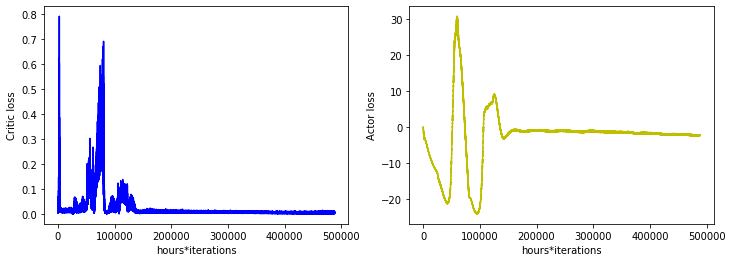

In [6]:
#Prints the actor and critic losses
fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(12,4)
plot1.plot(agents.critic_loss_list[0],'b')
plot2.plot(agents.actor_loss_list[0],'y')
plot1.set_xlabel('hours*iterations')
plot1.set_ylabel('Critic loss')
plot2.set_xlabel('hours*iterations')
plot2.set_ylabel('Actor loss')

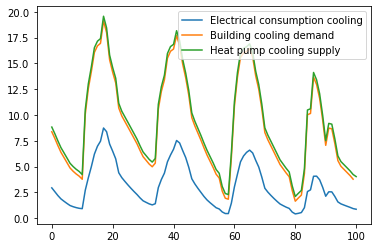

In [10]:
#Plots for the last 100 hours of the simulation
plt.plot(env.buildings[0].cooling_device.electrical_consumption_cooling[2400:])
plt.plot(env.buildings[0].sim_results['cooling_demand'][3500:6000].values[2400:])
plt.plot(env.buildings[0].cooling_device.cooling_supply[2400:])
plt.legend(['Electrical consumption cooling','Building cooling demand','Heat pump cooling supply'])

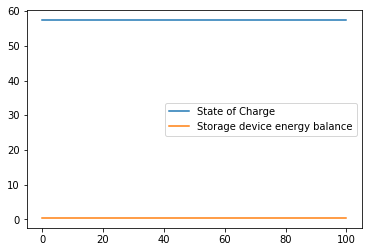

In [11]:
#Plots for the last 100 hours of the simulation
plt.plot(env.buildings[0].cooling_storage.soc_list[2400:])
plt.plot(env.buildings[0].cooling_storage.energy_balance_list[2400:])
plt.legend(['State of Charge','Storage device energy balance'])

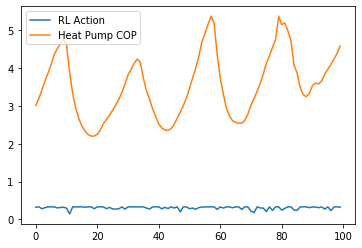

In [12]:
#Plots for the last 100 hours of the simulation
plt.plot(env.action_track[8][-100:])
plt.plot(env.buildings[0].cooling_device.cop_cooling_list[2400:2500])
plt.legend(['RL Action','Heat Pump COP'])

As the previous figure shows, the RL agent learns to store additional cooling energy when the coefficient of performance (COP) of the heat pump is higher and release it when it is lower. This helps reduce the overall energy consumption of the building.

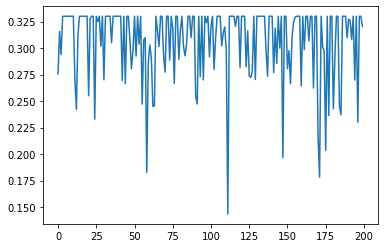

In [13]:
#Plots all the actions across episodes
plt.plot(env.action_track[8][-200:])

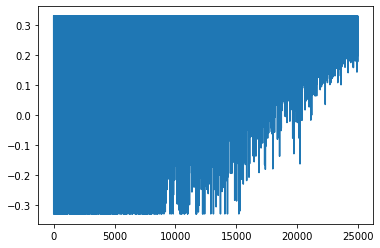

In [14]:
#Plots all the actions across episodes
plt.plot(env.action_track[8])